<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W2_Feeding_windowed_dataset_into_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

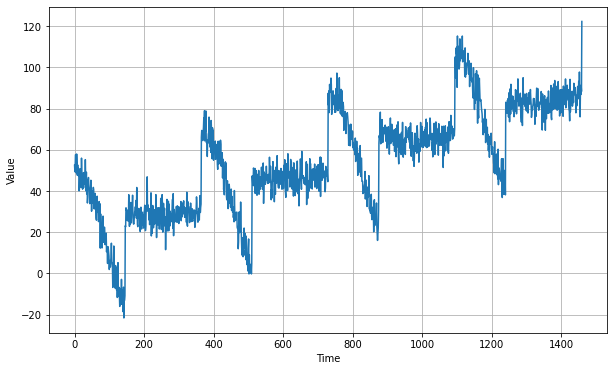

In [29]:
# Data generation
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Define the windowed_dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Create dataset from series and pass the series to it
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # Window the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # Mapping a dataset element to a (window_size + 1) batch size dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Shuffle the dataset at the shuffle_buffer and split into features and labels
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # Batch the select batch size
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset

In [0]:
# Split dataset into training and validation sets
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [32]:
# Buid the simple linear regression model

# Set the constants that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Create the dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create single dance layer
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
)

model.fit(
    dataset,
    epochs=100,
    verbose=1
)

print("Training complete")

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 3522.6787
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 274.5392
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 117.0838
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 103.3804
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 98.3188
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 96.1288
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 91.9021
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 88.9988
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 87.2549
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 83.2566
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 80.5558
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 79.2805
Epoch 13/100
31/31 [

In [33]:
# Print weight and bias
print("Layer weights {}".format(l0.get_weights()))

# weight -- shape (20, 1)
# bias -- shape (1, 1)

Layer weights [array([[-0.05220245],
       [ 0.02435948],
       [-0.00822864],
       [ 0.05589125],
       [-0.03172001],
       [ 0.00287203],
       [-0.00203481],
       [ 0.04173112],
       [-0.03535821],
       [-0.01021295],
       [ 0.02369543],
       [-0.02898759],
       [-0.006352  ],
       [-0.02910659],
       [ 0.08496435],
       [ 0.03680661],
       [ 0.09810794],
       [ 0.11488886],
       [ 0.23549539],
       [ 0.4687031 ]], dtype=float32), array([0.01377982], dtype=float32)]


In [34]:
# Predict next time step data from series[1:21]

# Past data
print(series[1:21])

# Predict next time step data
model.predict(series[1:21][np.newaxis])  # np.newaxis reshape series data to the input dimension

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]


array([[49.09089]], dtype=float32)

In [0]:
# Forecast every time points of time series
forecast = []

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

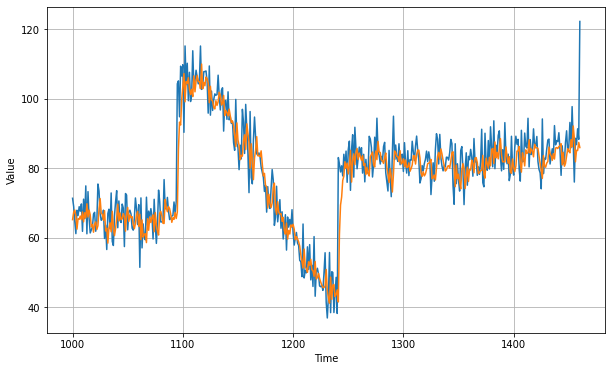

In [36]:
# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# Actual -- Blue, Prediction -- Orange

In [37]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# mae = np.abs(errors).mean()
# Same accuracy as moving average and differencing methods

5.0380135